<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Можно ли использовать сверточные сети для классификации текстов? Если нет обоснуйте :D, если да то как? как решить проблему с произвольной длинной входа?

Да, можно использовать посимвольное представления текста (не рассматривая слова вообще). Или можно использовать векторное представление текста - каждому тексту сопоставить вектор длины, равной количеству слов, и на месте нужного слова ставить 1, на остальных 0. Это и можно подавать на вход в нейронку. Мы сталкиваемся с проблемой, что в каждом тексте разное количество слов и вектора получаются разной длины. Для решения этой проблемы можно брать только векторы фиксированной длины, а остальное обрубать. Или докидовать символы типа #UNK.

**Вопрос 2**: Чем LSTM лучше/хуже чем обычная RNN?

В RNN присутсвует проблема затухания/взрывания градиентов, в связи с чем сеть быстро теряет информацию. LSTM решает эту проблему, применяя фильтры, таким образом, зануляются некоторые компоненты градиента.

**Вопрос 3**:  Выпишите производную $\frac{d c_{n+1}}{d c_{k}}$ для LSTM http://colah.github.io/posts/2015-08-Understanding-LSTMs/, объясните формулу, когда производная затухает, когда взрывается?

$\frac{d c_{n+1}}{d c_{k}} = \frac{d c_{n+1}}{d c_{n}}\frac{d c_{n}}{d c_{k}} = \frac{d c_{n+1}}{d c_{n}}\frac{d c_{n}}{d c_{n-1}}\frac{d c_{n-1}}{d c_{k}} = \cdots = \frac{d c_{n+1}}{d c_{n}} \cdots \frac{d c_{k+1}}{d c_{k}} = \Pi_{j=k}^{n-1}\frac{d c_{j+1}}{d c_{j}}$

Производная затухает, когда какие-то компоненты из произведения намного меньше остальных, и взрывается, когда намного больше.

**Вопрос 4**: Зачем нужен TBPTT почему BPTT плох?

TBPTT - то же самое, что BPTT, но с точкой остановки. То есть мы считаем производные до какого-то шага, потом просто обрубаем. Это необходимо для ускорения работы. 

**Вопрос 5**: Как комбинировать рекуррентные и сверточные сети, а главное зачем? Приведите несколько примеров реальных задач.

Комбинация сетей происходит таким образом: выход сверточной сети передается на вход в рекуррентную сеть. Это используется, например, при генерации подписей к изображением (данная задача), распознаванию объектов на изображениях, классификация фото/видео/адуио.

**Вопрос 6**: Объясните интуицию выбора размера эмбединг слоя? почему это опасное место?

<Ответ>

* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```, Александр Панин

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline. It can help u https://ars-ashuha.ru/slides/2016.11.11_ImageCaptioning/image_captionong.pdf 

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.

In [1]:
#!brew install wget
#!wget https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1 -O data.tar.gz
#!tar -zxvf data.tar.gz

### Data preprocessing

In [2]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 519 ms, sys: 670 ms, total: 1.19 s
Wall time: 1.38 s


In [3]:
print ("each image code is a 1000-unit vector:", img_codes.shape)
print (img_codes[0,:10])
print ('\n\n')
print ("for each image there are 5-7 descriptions, e.g.:\n")
print ('\n'.join(captions[0]))

each image code is a 1000-unit vector: (123287, 1000)
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [4]:
from collections import Counter

In [5]:
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [6]:
#%%time
#word_counts = Counter()
#for i in range(len(captions)):
#    for j in range(len(captions[i])):
#        word_counts += Counter(captions[i][j])

In [7]:
# save to json
import json
#with open('data.json', 'w') as fp:
#    json.dump(word_counts, fp)

In [8]:
# load json
with open('data.json', 'r') as fp:
    word_counts = json.load(fp)

In [9]:
vocab  = ['#UNK#', '#END', '#START']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

#assert (10000 <= n_tokens <= 10500)
print(n_tokens)

word_to_index = {w: i for i, w in enumerate(vocab)}

10373


In [10]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [11]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   3,   64,  322,  206,   32,   50,  588,   21,  171,  172,   36,
        1836,   14,   -1,   -1],
       [   3,  171,  172,  183, 1405,   43, 1836,   36,  186, 1381,  588,
          14,   -1,   -1,   -1],
       [   3,    4,  206,   32,   50,  588,   21,  171,   24, 3575,   65,
          27,  605,  353,   14],
       [   3,    4,    5,   75,  449,    9,    4,    5,  102,   14,   -1,
          -1,   -1,   -1,   -1],
       [   3,   64,  322,  206,   32,   50,  588,   21,  171,  172,   65,
          27, 3576,   14,   -1]], dtype=int32)

### Mah Neural Network

In [12]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 128 #pls change me if u want
LSTM_UNITS = 200 #pls change me if u want

In [13]:
!pip install -U numpy==1.11.0

Requirement already up-to-date: numpy==1.11.0 in /Users/lul/anaconda3/lib/python3.6/site-packages


In [14]:
import theano
import lasagne
import theano.tensor as T
from lasagne.layers import *

In [15]:
# Input Variable
sentences = T.imatrix('int32')# [batch_size x time] of word ids
image_vectors = T.matrix('int32') # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences, PAD_ix)

In [16]:
#network inputs
l_words = InputLayer((None, None), sentences)
l_mask = InputLayer((None, None), sentence_mask)

#embeddings for words 
############# TO CODE IT BY YOURSELF ##################
l_word_embeddings = EmbeddingLayer(l_words, n_tokens, EMBED_SIZE)

In [17]:
# input layer for image features
l_image_features = InputLayer((None, CNN_FEATURE_SIZE), image_vectors)

############# TO CODE IT BY YOURSELF ##################
#convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
#it's also a good idea to add some dropout here and there
l_image_features_small = DropoutLayer(l_image_features, 0.5) #<Apply Dropout Layer to regularise your Net>
l_image_features_small = DenseLayer(l_image_features_small, LSTM_UNITS) #<Apply Dense to acive LSTM_UNITS size of representation>

assert (l_image_features_small.output_shape == (None, LSTM_UNITS))

In [18]:
############# TO CODE IT BY YOURSELF ##################
# Concatinate image features and word embedings in one sequence 
decoder = LSTMLayer(l_word_embeddings,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,
                    mask_input=l_mask,
                    grad_clipping=1e50)

In [19]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer, UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder, (0, 1))
print ("broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape)

predicted_probabilities_each_tick = DenseLayer(
    broadcast_decoder_ticks,n_tokens, nonlinearity=lasagne.nonlinearities.softmax)

#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(
                        predicted_probabilities_each_tick, broadcast_layer=broadcast_decoder_ticks)

print ("output shape = ", predicted_probabilities.output_shape)

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert (predicted_probabilities.output_shape == (None, None, 10373))

broadcasted decoder shape =  (None, 200)
output shape =  (None, None, 10373)


In [20]:
next_word_probas = get_output(predicted_probabilities)

In [21]:
reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(next_word_probas[:, :-1].reshape((-1, n_tokens)),
                                                   reference_answers.reshape((-1,))
                                                  ).reshape(reference_answers.shape)

############# TO CODE IT BY YOURSELF ##################
loss = (loss * output_mask).sum() / output_mask.sum() #<mean over non-PAD tokens>

In [22]:
#trainable NN weights
############# TO CODE IT BY YOURSELF ##################
weights = get_all_params(predicted_probabilities, trainable=True)
lr = theano.shared(lasagne.utils.floatX(1e-2))
updates = lasagne.updates.adam(loss, weights, learning_rate=lr)

In [23]:
#compile a function that takes input sentence and image mask, outputs loss and updates weights
#please not that your functions must accept image features as FIRST param and sentences as second one
############# TO CODE IT BY YOURSELF ##################
train_step = theano.function([image_vectors, sentences], loss, updates=updates, allow_input_downcast=True)
val_step   = theano.function([image_vectors, sentences], loss, allow_input_downcast=True)

/Users/lul/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:5130: UserWarning: flatten outdim parameter is deprecated, use ndim instead.
  "flatten outdim parameter is deprecated, use ndim instead.")


# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [24]:
captions = np.array(captions)

In [25]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(images), size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = list(map(choice, captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [26]:
generate_batch(img_codes,captions, 3)

(array([[-5.30794716, -4.6321907 ,  2.25939631, ..., -2.04265618,
         -1.68389666,  1.74470687],
        [-1.61982155, -1.29207456,  3.18103266, ..., -3.52687645,
          0.79460204, -0.07235372],
        [-1.527879  , -2.63614273, -1.22889626, ..., -2.04206872,
          3.37474966, -0.69135356]], dtype=float32),
 array([[   3,    4,   42,   36, 1269, 1554,  710,    4, 2091,   21, 2488,
            6,  101,   36,   33,   14],
        [   3,    4,   50, 1003, 1021,   36,  816,  722,    6,    4, 1108,
          461,   14,   -1,   -1,   -1],
        [   3,    4,    5, 3253,    9,  160, 3898,   32, 2468,  311,    4,
           42,   14,   -1,   -1,   -1]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [27]:
batch_size = 128 #adjust me
n_epochs   = 10 #adjust me
n_batches_per_epoch = 16 #adjust me
n_validation_batches = 5 #how many batches are used for validation after each epoch

In [28]:
from tqdm import tqdm

for epoch in range(n_epochs):
    lr.set_value(lasagne.utils.floatX(lr.get_value() * 0.9))
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")

  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 0, train loss: 6.414435292466905, val loss: 5.506217407541682


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 1, train loss: 5.320322296242689, val loss: 5.1188503145963455


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 2, train loss: 4.824359959787281, val loss: 4.611615634930696


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 3, train loss: 4.492347025269339, val loss: 4.3258826013828315


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 4, train loss: 4.225615739092251, val loss: 4.154025894254049


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 5, train loss: 4.062966453830219, val loss: 3.9975902982761893


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 6, train loss: 4.0319567298271, val loss: 3.9299838784743897


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 7, train loss: 3.913452050303074, val loss: 3.8687506379801326


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 8, train loss: 3.805089165172144, val loss: 3.756619536039217


100%|██████████| 16/16 [00:55<00:00,  3.17s/it]



Epoch: 9, train loss: 3.7807235619965742, val loss: 3.7393485517147758
Finish :)


In [34]:
from tqdm import tqdm

for epoch in range(n_epochs):
    lr.set_value(lasagne.utils.floatX(lr.get_value() * 0.9))
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")

  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 0, train loss: 3.7406827298923284, val loss: 3.7233474716376236


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 1, train loss: 3.663779316780341, val loss: 3.6593905825860906


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 2, train loss: 3.6742441632517537, val loss: 3.649902814407781


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 3, train loss: 3.6115684137460806, val loss: 3.5702595602996596


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 4, train loss: 3.5579729345530273, val loss: 3.5544571476863838


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 5, train loss: 3.5525600137511564, val loss: 3.4839396200059896


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 6, train loss: 3.5067165232859665, val loss: 3.498995466618416


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 7, train loss: 3.4885503060497687, val loss: 3.477169847470124


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 8, train loss: 3.4860734077526114, val loss: 3.48156141123775


100%|██████████| 16/16 [00:54<00:00,  3.10s/it]



Epoch: 9, train loss: 3.484613536821601, val loss: 3.4434698106906234
Finish :)


In [40]:
from tqdm import tqdm

for epoch in range(n_epochs):
    lr.set_value(lasagne.utils.floatX(lr.get_value() * 0.9))
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")

  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 0, train loss: 3.4419474094591873, val loss: 3.534634273291698


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 1, train loss: 3.4077808099507623, val loss: 3.40042381927048


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 2, train loss: 3.3912738552848283, val loss: 3.426458244039723


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 3, train loss: 3.402850532951324, val loss: 3.4278679532550584


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 4, train loss: 3.431536101073278, val loss: 3.34127205920259


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 5, train loss: 3.3724014777903, val loss: 3.4228645989255484


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 6, train loss: 3.381274520755114, val loss: 3.353997592922579


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 7, train loss: 3.3566770008163127, val loss: 3.3966105218416844


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch: 8, train loss: 3.394265665249305, val loss: 3.395519269284852


100%|██████████| 16/16 [00:53<00:00,  3.25s/it]



Epoch: 9, train loss: 3.4111794305070577, val loss: 3.403389252358213
Finish :)


### apply trained model

In [41]:
#the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl', 'rb'), encoding='latin1')
lenet_weights = lenet_weights['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [42]:
from pretrained_lenet import build_model,preprocess,MEAN_VALUES
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
from math import ceil
im = plt.imread('data/Dog-and-Cat.jpg')
print(im.shape)
import skimage.transform
MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))

# Resize so smallest dim = 224, preserving aspect ratio
h, w, _ = im.shape
if h < w:
    im = skimage.transform.resize(im, (224, ceil(w*224/h)), preserve_range=True)
else:
    im = skimage.transform.resize(im, (h*224/w, 224), preserve_range=True)

# Central crop to 224x224
h, w, _ = im.shape
im = im[h//2-112:h//2+112, w//2-112:w//2+112]

rawim = np.copy(im).astype('uint8')

# Shuffle axes to c01
im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)

# Convert to BGR
im = im[::-1, :, :]

im = im - MEAN_VALUES
img = im[np.newaxis].astype('float32')

(640, 1024, 3)


/Users/lul/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


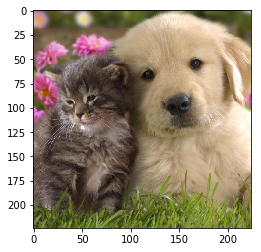

In [43]:
#deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

## Generate caption

In [44]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

In [45]:
for i in range(10):
    print (' '.join(generate_caption(img,t=1.)[1:-1]))

yellow bowl has a baby scattered seed mirror
cat near a bed
a close sitting on top of a stunt tail
a cat eating a wooden microwave on top of an road
cat on a blue table and a blue room of sheep
on one walking on the side top of a house in front of a large lawn
and cats with a dining and pizza in front
library of a baby and white knife in dirt
the woman standing in a couch looking onto a window
a black cat standing in a wall surrounded in the floor


# Bonus Part
- Use ResNet Instead of GoogLeNet
- Use W2V as embedding
- Use Attention :) 

# Pass Assignment https://goo.gl/forms/2qqVtfepn0t1aDgh1 